# Experiment w clustering for online word detection

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from xournalpp_htr.documents import XournalppDocument

## Load example data

In [2]:
PATH = "../tests/data/2024-07-26_minimal.xopp"  # Acutal baseline
# PATH = "/home/martin/data/xournalpp_htr/test.xopp"  # Exciting experiment

xpp_doc = XournalppDocument(PATH)

/home/martin/Development/xournalpp_htr/xournalpp_htr/documents.py:128: XMLParsedAsHTMLWarning: It looks like you're parsing an XML document using an HTML parser. If this really is an HTML document (maybe it's XHTML?), you can ignore or filter this warning. If it's XML, you should know that using an XML parser will be more reliable. To parse this document as XML, make sure you have the lxml package installed, and pass the keyword argument `features="xml"` into the BeautifulSoup constructor.
  bs_content = bs(content, "lxml")


## Settings

In [3]:
I_PAGE = 0
DPI = 72

## Plot example data as-is w/o segmentation

In [4]:
page = xpp_doc.pages[I_PAGE]

all_strokes = []

for layer in page.layers:
    for stroke in layer.strokes:
        x = stroke.x / DPI
        y = stroke.y / DPI

        y *= -1

        all_strokes.append({"x": x, "y": y, "x_mean": x.mean(), "y_mean": y.mean()})

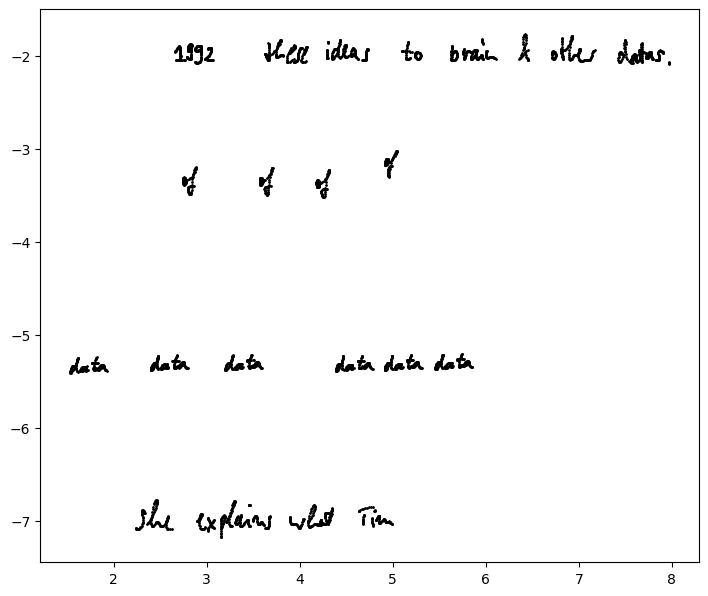

In [5]:
plt.figure(
    figsize=(
        float(page.meta_data["width"]) / DPI,
        float(page.meta_data["height"]) / DPI,
    )
)

for stroke in all_strokes:
    x = stroke["x"]
    y = stroke["y"]
    plt.scatter(x, y, s=1, c="black")

plt.gca().set_aspect("equal")
plt.show()

## Attempt 1

Plot mean of each stroke on top of stroke.

In [6]:
THRESHOLD = 1e-1

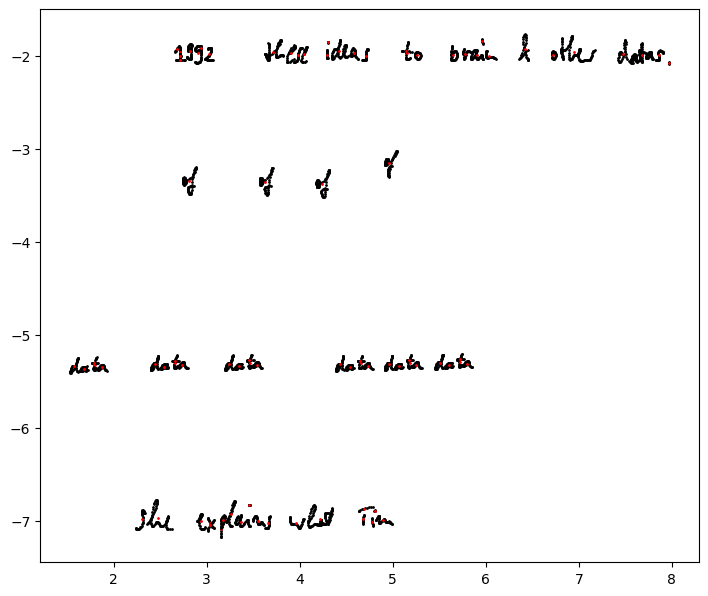

In [7]:
plt.figure(
    figsize=(
        float(page.meta_data["width"]) / DPI,
        float(page.meta_data["height"]) / DPI,
    )
)

for stroke in all_strokes:
    plt.scatter(stroke["x"], stroke["y"], s=1, c="black")
    plt.scatter(stroke["x_mean"], stroke["y_mean"], c="red", s=1)

plt.gca().set_aspect("equal")
plt.show()

Next, I compute the distance between the strokes and threshold it:

In [8]:
distances = np.infty * np.ones((len(all_strokes), len(all_strokes)))

In [9]:
for i in range(len(all_strokes)):
    for j in range(i - 1 + 1):
        element = (all_strokes[i]["x_mean"] - all_strokes[j]["x_mean"]) ** 2 + (
            all_strokes[i]["y_mean"] - all_strokes[j]["y_mean"]
        ) ** 2
        distances[i, j] = element

In [10]:
distances[distances != -1.0].min(), distances[distances != -1.0].max()

(0.00041327541594056525, inf)

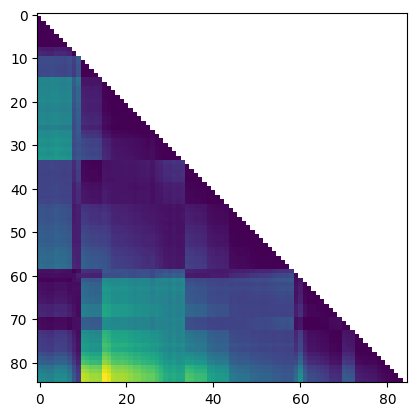

In [11]:
plt.figure()
plt.imshow(distances)
plt.show()

Now construct the clusters (inefficiently for now just to get it running at first):

In [12]:
stroke_groups = []

for i in range(1, len(all_strokes)):
    # Check if I want to skip `i` b/c it's already part of a stroke group
    skip_i = False
    for stroke_group in stroke_groups:
        if i in stroke_group:
            skip_i = True
            break
    if skip_i:
        continue

    # Construct a stroke group
    similar_strokes = np.where(distances[i] <= THRESHOLD)[0]

    # print(i)

Again, i didn't manage to implement it naively b/c I wasn't concentrated. instead, I will use clustering!

In [13]:
raise NotImplementedError("i need to implement that!")

already_used = np.zeros(len(all_strokes), dtype=bool)

stroke_groups = []

for i in range(1, len(all_strokes)):
    if not already_used[i]:
        word_members = []
        similar_strokes = np.where(distances[i] <= THRESHOLD)[0]
        similar_strokes = similar_strokes.tolist() + [
            i,
        ]

        print(similar_strokes)

        stroke_groups.append(similar_strokes)

        for j in similar_strokes:
            already_used[j] = True

NotImplementedError: i need to implement that!

To read: [1](https://stats.stackexchange.com/questions/148161/clustering-from-similarity-distance-matrix), [2](https://scikit-learn.org/dev/modules/generated/sklearn.cluster.SpectralClustering.html), [3](https://stats.stackexchange.com/questions/475687/clustering-given-distance-matrix-and-k-in-python).

The problem of this approach is that the thresholding is not scale invariant, i.e. larger written words will fail to be recognised to be a word b/c the strokes are too far apart.

## Attempt 2

B/c/ I didn't manage to get the naive approach running (lack of concentration and problem understanding), I decided to try out clustering directly.

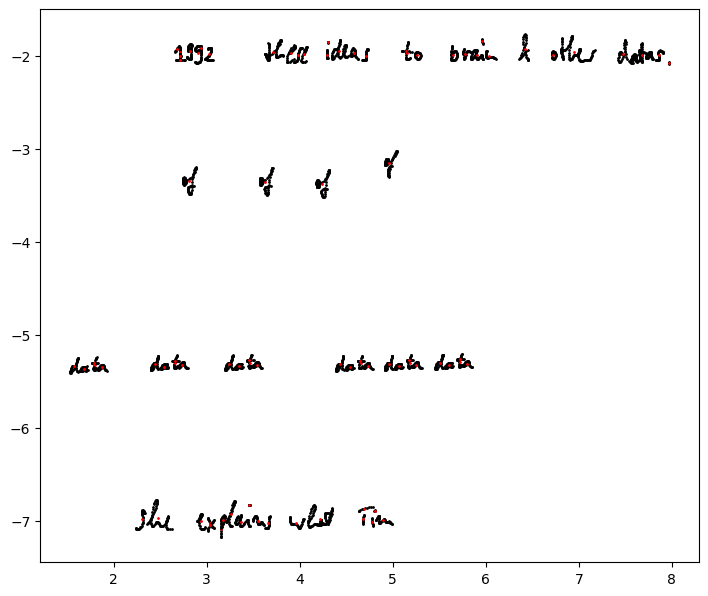

In [14]:
plt.figure(
    figsize=(
        float(page.meta_data["width"]) / DPI,
        float(page.meta_data["height"]) / DPI,
    )
)

for stroke in all_strokes:
    plt.scatter(stroke["x"], stroke["y"], s=1, c="black")
    plt.scatter(stroke["x_mean"], stroke["y_mean"], c="red", s=1)

plt.gca().set_aspect("equal")
plt.show()

First, assemble the `X` variable with covariates:

In [15]:
X = []
for stroke in all_strokes:
    X.append([stroke["x_mean"], stroke["y_mean"]])
X = np.array(X)
X.shape

(85, 2)

Next, try out [AgglomerativeClustering](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html#sklearn.cluster.AgglomerativeClustering) w hard-coded number of clusters to check if it then finds the right words:

In [16]:
from sklearn.cluster import AgglomerativeClustering

N_CLUSTERS = 22
DISTANCE_THRESHOLD = None

N_CLUSTERS = 10
DISTANCE_THRESHOLD = None

N_CLUSTERS = None
DISTANCE_THRESHOLD = 1e0  # One could maybe tune it by investigating nr of clusters over distance threshold

clustering = AgglomerativeClustering(
    n_clusters=N_CLUSTERS, distance_threshold=DISTANCE_THRESHOLD
).fit(X)  # I hard-code 22 b/c I counted that there're 22 clusters
np.unique(clustering.labels_), np.unique(clustering.labels_).shape

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 (20,))

Next, check if the clusters make sense:

0 [17 18 19 20 21 22 23 24 25 26]
1 [ 8 59]
2 [81 82 83 84]
3 [78 79 80]
4 [73 74 75 76 77]
5 [39 40 41 42 43]
6 [62 63 64 65 66]
7 [0 1 2 3 4 5 6 7]
8 [61 70 71 72]
9 [49 50 51 52 53]
10 [54 55 56 57 58]
11 [27 28]
12 [60]
13 [34 35 36 37 38]
14 [15 16]
15 [67 68 69]
16 [9]
17 [44 45 46 47 48]
18 [10 11 12 13 14]
19 [29 30 31 32 33]


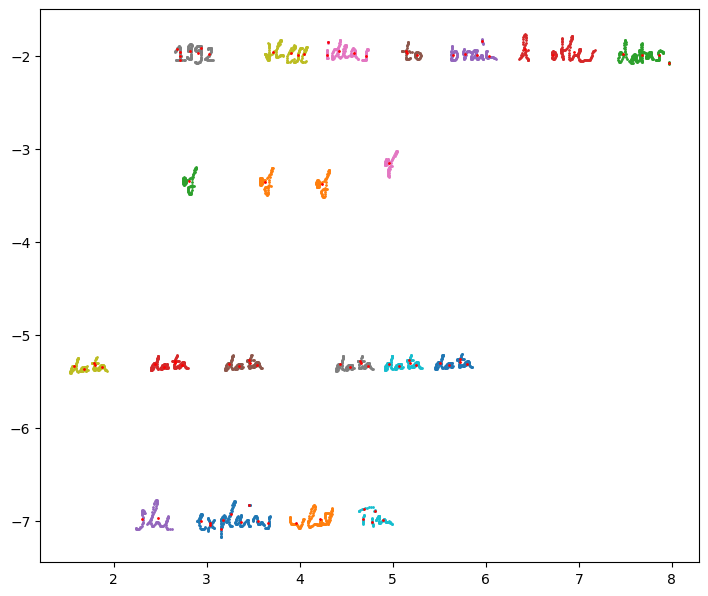

In [17]:
plt.figure(
    figsize=(
        float(page.meta_data["width"]) / DPI,
        float(page.meta_data["height"]) / DPI,
    )
)

for i_cluster in np.unique(clustering.labels_):
    stroke_indices = np.where(clustering.labels_ == i_cluster)[0]

    print(i_cluster, stroke_indices)

    x_coords = []
    y_coords = []
    x_coords_mean = []
    y_coords_mean = []
    for stroke_index in stroke_indices:
        stroke = all_strokes[stroke_index]
        x_coords += stroke["x"].tolist()
        y_coords += stroke["y"].tolist()
        x_coords_mean.append(stroke["x_mean"])
        y_coords_mean.append(stroke["y_mean"])

    plt.scatter(x_coords, y_coords, s=1)
    plt.scatter(x_coords_mean, y_coords_mean, c="red", s=1)

plt.gca().set_aspect("equal")
plt.show()

Interestingly, the result is not too bad!


Next, investigate number of clusters against threshold:

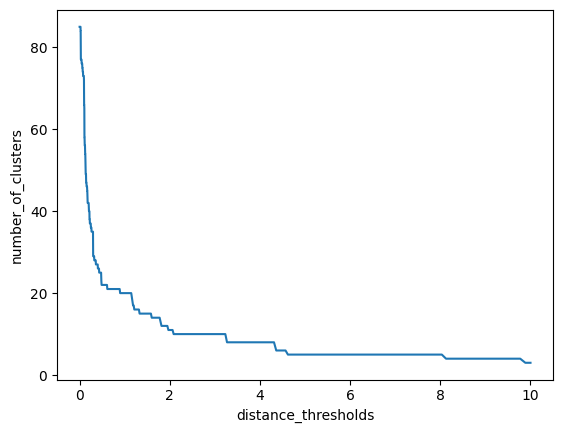

In [18]:
N_CLUSTERS = None

distance_thresholds = []
number_of_clusters = []

for DISTANCE_THRESHOLD in np.logspace(-4, 1, 1000):
    clustering = AgglomerativeClustering(
        n_clusters=N_CLUSTERS, distance_threshold=DISTANCE_THRESHOLD
    ).fit(X)

    distance_thresholds.append(DISTANCE_THRESHOLD)
    number_of_clusters.append(np.unique(clustering.labels_).shape)

plt.figure()
plt.plot(distance_thresholds, number_of_clusters)
plt.xlabel("distance_thresholds")
plt.ylabel("number_of_clusters")
plt.show()

^-- Unfortunately, one cannot see a clear sign of what distance threshold to pick. This is probably a function of the the content of the page (e.g. diagrams, written text height, etc).

Next, question: Is this approach robust against larger handwriting?

Next, plot the dendrogram, see [here](https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html#sphx-glr-auto-examples-cluster-plot-agglomerative-dendrogram-py).

Next, try out DBSCAN! Also see [here](https://scikit-learn.org/stable/modules/clustering.html).

Also next, try out another document to play around with.

Question: Is my OnlineHTR model robust against rotated text?! Maybe one should rotate the text first?

Note: It is probably worth it to write a bit of infrastructure code to experiment more (and easier and easier to compare) with these clustering approaches.

Next: Feed these sequences to `OnlineHTR` or retrained `SimpleHTR` nmodel.

## Attemp 3: DBSCAN

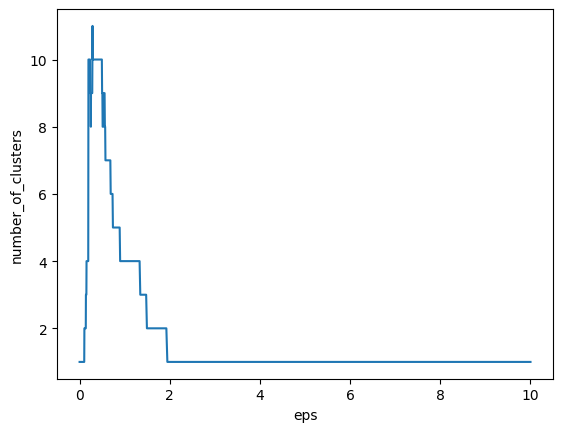

In [19]:
from sklearn.cluster import DBSCAN

eps_values = []
number_of_clusters = []

for EPS in np.logspace(-4, 1, 1000):
    clustering = DBSCAN(
        eps=EPS,
    ).fit(X)

    eps_values.append(EPS)
    number_of_clusters.append(np.unique(clustering.labels_).shape)

plt.figure()
plt.plot(eps_values, number_of_clusters)
plt.xlabel("eps")
plt.ylabel("number_of_clusters")
plt.show()

This graph is a bit unconclusive for me.

In [20]:
eps_max = eps_values[np.argmax(number_of_clusters)]
print(eps_max)

clustering = DBSCAN(
    eps=eps_max,
).fit(X)

0.28738126918510665


-1 [ 8  9 15 16 27 28 59 60 61 67 68 69 78 79 80 81 82 83 84]
0 [0 1 2 3 4 5 6 7]
1 [10 11 12 13 14]
2 [17 18 19 20 21 22 23 24 25 26]
3 [29 30 31 32 33]
4 [34 35 36 37 38]
5 [39 40 41 42 43]
6 [44 45 46 47 48 49 50 51 52 53 54 55 56 57 58]
7 [62 63 64 65 66]
8 [70 71 72]
9 [73 74 75 76 77]


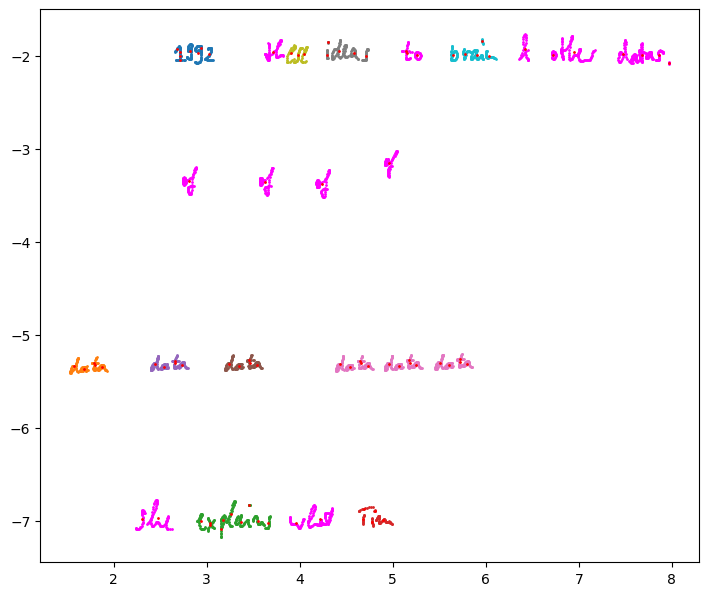

In [21]:
plt.figure(
    figsize=(
        float(page.meta_data["width"]) / DPI,
        float(page.meta_data["height"]) / DPI,
    )
)

for i_cluster in np.unique(clustering.labels_):
    stroke_indices = np.where(clustering.labels_ == i_cluster)[0]

    print(i_cluster, stroke_indices)

    x_coords = []
    y_coords = []
    x_coords_mean = []
    y_coords_mean = []
    for stroke_index in stroke_indices:
        stroke = all_strokes[stroke_index]
        x_coords += stroke["x"].tolist()
        y_coords += stroke["y"].tolist()
        x_coords_mean.append(stroke["x_mean"])
        y_coords_mean.append(stroke["y_mean"])

    if i_cluster == -1:
        plt.scatter(x_coords, y_coords, s=1, alpha=1, c="fuchsia")
    else:
        plt.scatter(x_coords, y_coords, s=1)
    plt.scatter(x_coords_mean, y_coords_mean, c="red", s=1)

plt.gca().set_aspect("equal")
plt.show()

The DBSCAN method seems to throw many of the words in the noisy class; this is probably worth investigating. Other than that, it seems to work OK-ish.

Interestingly, I think the biggest problem for the OnlineHTR model would be the different line positions based on the way it was trained. Hence, one could maybe put extra emphasis on clusters being on similar y values.

NEXT: Spectral clustering!

I have to say that I am unclear if a heuristic (i.e. a clustering algo w/ smartly chosen parameters) is really enough. Certainly for now, but a fully data-driven way would be better to accommodate different writers. This is probably relevant for a next iteration of the model.

## Attempt 4: Spectral clustering

/home/martin/anaconda3/envs/xournalpp_htr/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


0 [ 8  9 59]
1 [18 19 20 21 22 23 24 25 26 27]
2 [61 62 63 64 70 71 72]
3 [54 55 56 57 58]
4 [80 81 82 83 84]
5 [28 29 30 31 32 33]
6 [10 11 12 13 14]
7 [15 16 17]
8 [45 46 47 48 49 50 51 52 53]
9 [34 35 36 37 38 39 40]
10 [73 74 75 76 77 78 79]
11 [0 1 2 3 4 5 6 7]
12 [60]
13 [41 42 43 44]
14 [65 66 67 68 69]


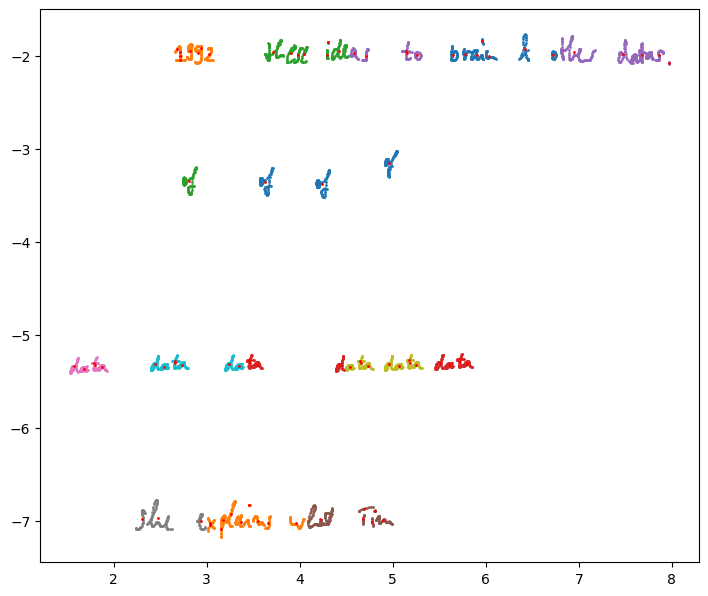

In [25]:
from sklearn.cluster import SpectralClustering

clustering = SpectralClustering(
    n_clusters=15,  # 21,
    affinity="nearest_neighbors",
).fit(X)

plt.figure(
    figsize=(
        float(page.meta_data["width"]) / DPI,
        float(page.meta_data["height"]) / DPI,
    )
)

for i_cluster in np.unique(clustering.labels_):
    stroke_indices = np.where(clustering.labels_ == i_cluster)[0]

    print(i_cluster, stroke_indices)

    x_coords = []
    y_coords = []
    x_coords_mean = []
    y_coords_mean = []
    for stroke_index in stroke_indices:
        stroke = all_strokes[stroke_index]
        x_coords += stroke["x"].tolist()
        y_coords += stroke["y"].tolist()
        x_coords_mean.append(stroke["x_mean"])
        y_coords_mean.append(stroke["y_mean"])

    if i_cluster == -1:
        plt.scatter(x_coords, y_coords, s=1, alpha=1, c="fuchsia")
    else:
        plt.scatter(x_coords, y_coords, s=1)
    plt.scatter(x_coords_mean, y_coords_mean, c="red", s=1)

plt.gca().set_aspect("equal")
plt.show()

This does not look good.